# Data analysis: Covid cases over time

Data analysis of daily new covid cases in different countries, using data from:

https://github.com/CSSEGISandData/COVID-19

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
plt.style.use("ggplot")

## Import and clean up data

In [3]:
def read_csv(file, response):
    return (
        pd.read_csv(file)
        # Remove unused columns
        .drop(["Lat", "Long"], axis=1)
        # Make the date a column
        .melt(id_vars=["Province/State", "Country/Region"], var_name="Date", value_name=response)
        # Convert the date from string to a real date
        .assign(**{"Date": lambda df: pd.to_datetime(df["Date"])})
        # Aggregate provinces
        .groupby(["Country/Region", "Date"])
        .sum()
        # Convert cumulative totals to daily increments
        .groupby(level="Country/Region")
        .diff()
    )

In [4]:
cases_df = read_csv("time_series_covid19_confirmed_global.csv", "Cases")

In [5]:
cases_df.head(5)

Cases
Country/Region Date             
Afghanistan    2020-01-22    NaN
               2020-01-23    0.0
               2020-01-24    0.0
               2020-01-25    0.0
               2020-01-26    0.0

In [6]:
deaths_df = read_csv("time_series_covid19_deaths_global.csv", "Deaths")

In [7]:
deaths_df.head(5)

Deaths
Country/Region Date              
Afghanistan    2020-01-22     NaN
               2020-01-23     0.0
               2020-01-24     0.0
               2020-01-25     0.0
               2020-01-26     0.0

In [8]:
df = cases_df.join(deaths_df)

In [9]:
df.head(5)

Cases  Deaths
Country/Region Date                     
Afghanistan    2020-01-22    NaN     NaN
               2020-01-23    0.0     0.0
               2020-01-24    0.0     0.0
               2020-01-25    0.0     0.0
               2020-01-26    0.0     0.0

## Analyze

In [10]:
date_from = pd.to_datetime("2021-01-01")
date_to   = pd.to_datetime("2021-12-31")

countries = sorted([
    "Poland",
    "Czechia",
    "Germany",
    "Austria",
    "United Kingdom"
])

In [11]:
def plot(df):
    fig, ax = plt.subplots(figsize=(16,5))
    for col in df.columns:
        ax.plot(df.index, df[col], label=col)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

### Plot cases day by day

In [12]:
cases_day_by_day = df.loc[(countries, slice(date_from, date_to)), "Cases"]
cases_day_by_day.groupby(level="Country/Region").head()

Country/Region  Date      
Austria         2021-01-01     2096.0
                2021-01-02     1391.0
                2021-01-03     1466.0
                2021-01-04     1642.0
                2021-01-05     2311.0
Czechia         2021-01-01    13361.0
                2021-01-02     3447.0
                2021-01-03     5012.0
                2021-01-04     6233.0
                2021-01-05    12921.0
Germany         2021-01-01    15575.0
                2021-01-02    11036.0
                2021-01-03    10356.0
                2021-01-04    12320.0
                2021-01-05    18349.0
Poland          2021-01-01    10896.0
                2021-01-02     7006.0
                2021-01-03     5782.0
                2021-01-04     4385.0
                2021-01-05     7596.0
United Kingdom  2021-01-01    53458.0
                2021-01-02    57853.0
                2021-01-03    55157.0
                2021-01-04    58923.0
                2021-01-05    61087.0
Name: Cases, dtype: flo

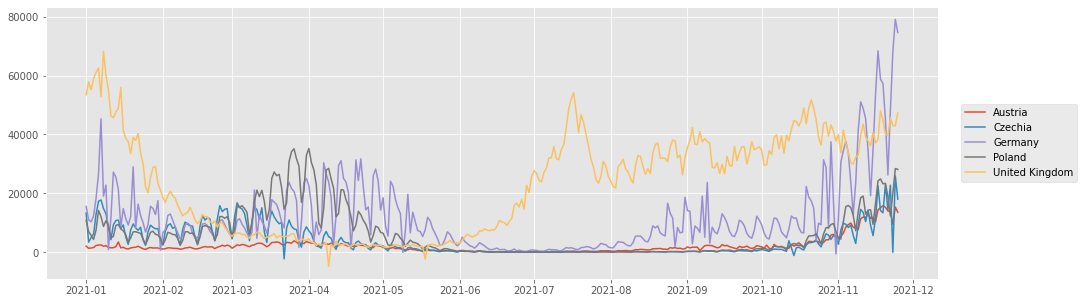

In [13]:
plot(cases_day_by_day.unstack(level="Country/Region"))

### Plot cases week-by-week

In [14]:
def week_start(dt):
    return dt - timedelta(days=dt.weekday())

In [15]:
cases_week_by_week = (
    cases_df.loc[(countries, slice(week_start(date_from), date_to)), "Cases"]
    .groupby(level="Country/Region")
    .resample("1W", level="Date")
    .sum()
)
cases_week_by_week.groupby(level="Country/Region").head()

Country/Region  Date      
Austria         2021-01-03     13876.0
                2021-01-10     14954.0
                2021-01-17     13056.0
                2021-01-24     10936.0
                2021-01-31      9684.0
Czechia         2021-01-03     69882.0
                2021-01-10     90684.0
                2021-01-17     57994.0
                2021-01-24     48458.0
                2021-01-31     47157.0
Germany         2021-01-03    125257.0
                2021-01-10    145514.0
                2021-01-17    120719.0
                2021-01-24     97640.0
                2021-01-31     77890.0
Poland          2021-01-03     60763.0
                2021-01-10     66960.0
                2021-01-17     50060.0
                2021-01-24     39863.0
                2021-01-31     37940.0
United Kingdom  2021-01-03    367471.0
                2021-01-10    418669.0
                2021-01-17    324372.0
                2021-01-24    252117.0
                2021-01-31    170326.

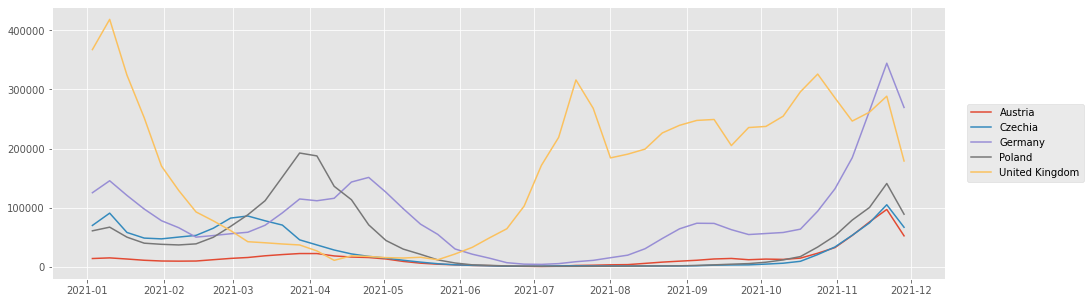

In [16]:
plot(cases_week_by_week.unstack(level="Country/Region"))

### Plot moving average of cases

In [24]:
def moving_average(df, date_from, date_to):
    window_days = 7
    return (
        df.loc[(slice(None), slice(date_from - timedelta(days=window_days-1), date_to)), :]
        .groupby(level="Country/Region")
        .apply(lambda s: s.rolling(7).mean())
        .loc[(countries, slice(date_from, date_to)), :]
    )

In [25]:
cases_moving_average = moving_average(df.loc[countries], date_from, date_to)
cases_moving_average.groupby(level="Country/Region").tail(10)

Cases      Deaths
Country/Region Date                                
Austria        2021-11-16  11732.428571   36.142857
               2021-11-17  12163.571429   38.714286
               2021-11-18  12616.428571   43.142857
               2021-11-19  13189.428571   44.285714
               2021-11-20  13495.857143   43.428571
               2021-11-21  13851.571429   44.142857
               2021-11-22  14125.428571   42.285714
               2021-11-23  14004.000000   43.857143
               2021-11-24  14139.571429   47.428571
               2021-11-25  13917.714286   47.142857
Czechia        2021-11-16  11312.714286   66.142857
               2021-11-17  12456.428571   68.571429
               2021-11-18  12549.285714   68.571429
               2021-11-19  12978.142857   74.857143
               2021-11-20  14234.714286   82.000000
               2021-11-21  14983.714286   85.428571
               2021-11-22  17427.714286  109.000000
               2021-11-23  15777.142857   95.428571
               2021-11-24  16257.714286   99.857143
               2021-11-25  16809.142857  107.714286
Germany        2021-11-16  41052.000000  187.142857
               2021-11-17  43521.857143  191.571429
               2021-11-18  44941.000000  193.857143
               2021-11-19  46647.571429  195.714286
               2021-11-20  48201.000000  198.571429
               2021-11-21  49206.428571  201.428571
               2021-11-22  51053.428571  207.285714
               2021-11-23  53113.714286  213.571429
               2021-11-24  54640.142857  225.571429
               2021-11-25  56898.857143  247.000000
Poland         2021-11-16  15065.000000  168.714286
               2021-11-17  15878.571429  196.285714
               2021-11-18  16711.857143  210.000000
               2021-11-19  18182.428571  263.428571
               2021-11-20  19485.285714  280.000000
               2021-11-21  20124.714286  279.285714
               2021-11-22  20534.285714  278.714286
               2021-11-23  21009.142857  295.285714
               2021-11-24  21607.714286  294.857143
               2021-11-25  22069.285714  313.142857
United Kingdom 2021-11-16  39168.285714  148.857143
               2021-11-17  38961.857143  146.714286
               2021-11-18  39610.714286  146.857143
               2021-11-19  40423.000000  148.857143
               2021-11-20  40758.142857  147.714286
               2021-11-21  41234.000000  147.428571
               2021-11-22  41946.571429  147.142857
               2021-11-23  42788.000000  140.142857
               2021-11-24  43458.857143  132.714286
               2021-11-25  43349.428571  125.285714

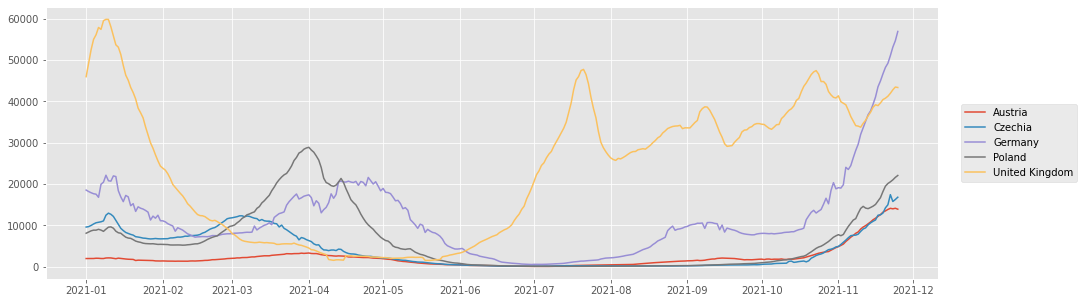

In [26]:
plot(cases_moving_average.loc[:, "Cases"].unstack(level="Country/Region"))

### Compare 2020 and 2021

In [27]:
def moving_average_year_to_year(df, date_from, date_to):
    levels = [countries, pd.date_range(date_from, date_to)]
    index = pd.MultiIndex.from_product(levels, names=df.index.names)

    return (
        moving_average(df.loc[countries], date_from, date_to)
        .reindex(index)
        .reset_index()
        .assign(**{
            "Year": lambda df: df["Date"].dt.year,
            "Day": lambda df: df["Date"].dt.strftime("%m-%d")
        })
        .drop(columns=["Date"])
        .set_index(["Country/Region", "Year", "Day"])
        .sort_index()
    )

In [28]:
cases_year_to_year = moving_average_year_to_year(df.loc[countries], pd.to_datetime("2020-01-01"), pd.to_datetime("2021-12-31"))
cases_year_to_year.head(5)

Cases  Deaths
Country/Region Year Day                 
Austria        2020 01-01    NaN     NaN
                    01-02    NaN     NaN
                    01-03    NaN     NaN
                    01-04    NaN     NaN
                    01-05    NaN     NaN

In [29]:
def plot_cases_year_to_year(df):
    countries, years, days = df.index.levels
    
    fig, axs = plt.subplots(nrows=len(countries), ncols=2, figsize=(16, 24))
    plt.subplots_adjust(hspace=0.45)
    
    for axs_row, country in zip(axs, countries):
        for ax, response in zip(axs_row, ["Cases", "Deaths"]):
            for year in years:
                cases = df.loc[(country, year)]
                ax.plot(cases.index, cases[response], label=year)

            ax.set_title(f"{country} - {response}")
            ax.set_xticks([day for day in days if day.endswith("-01")])
            ax.legend(loc="center", ncol=2, bbox_to_anchor=(0.5, -0.2))

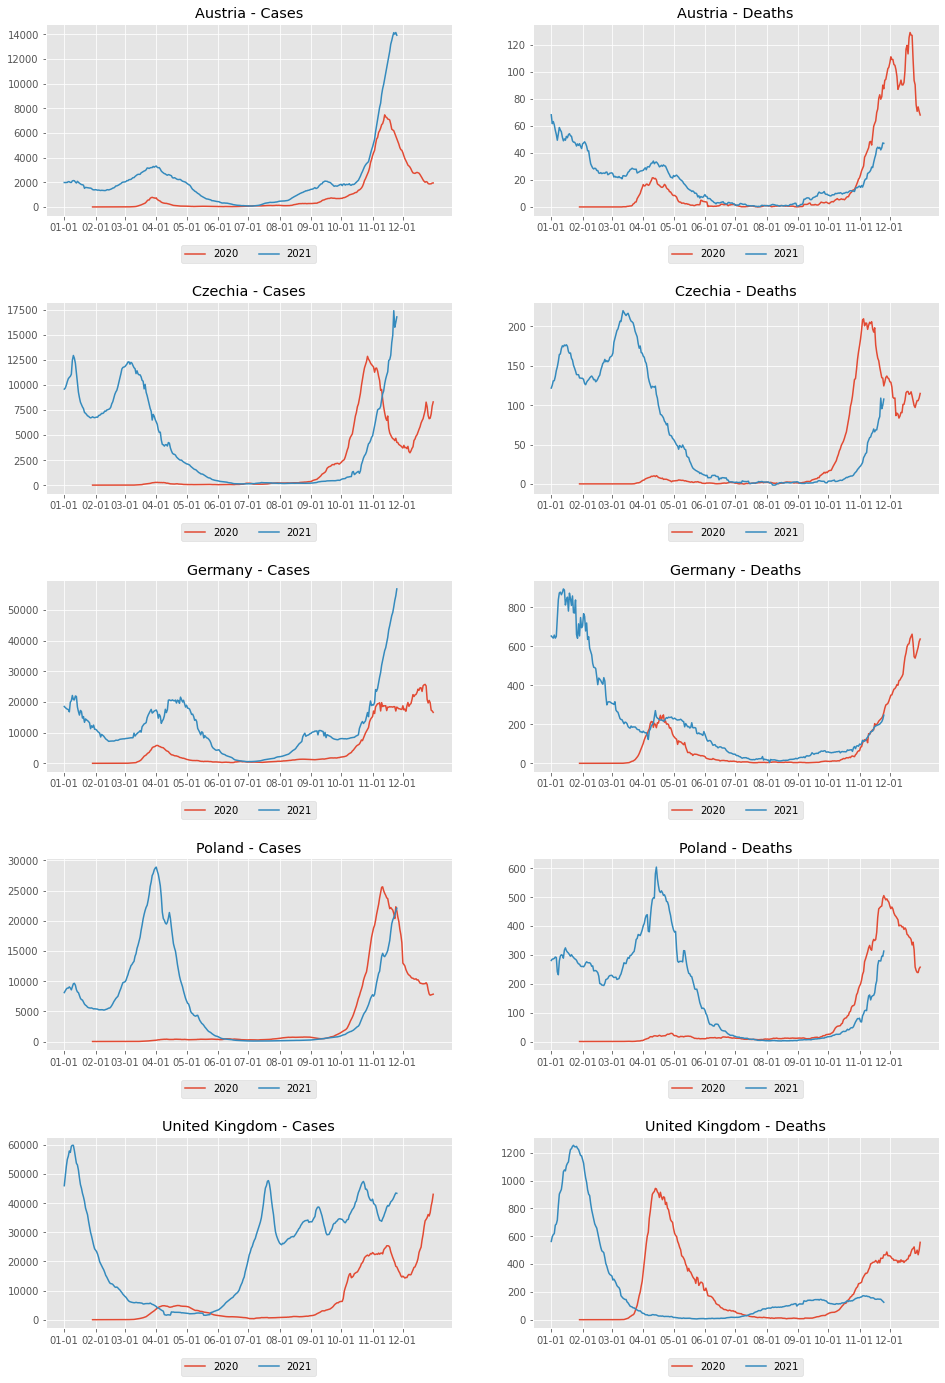

In [30]:
plot_cases_year_to_year(cases_year_to_year)